<a href="https://colab.research.google.com/github/liz-lewis-manchester/CNM_2025_group_11/blob/main/coursework_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter end of time domain (s): 300
Enter temporal resolution dt (s): 1
Enter spatial resolution (m): 1
Enter the flow speed (m/s): 0.1
Enter the decay constant (1/s): 0
Enter the perturbation factor: 0
Upload your initial conditions CSV file:


Saving initial_conditions.csv to initial_conditions (7).csv


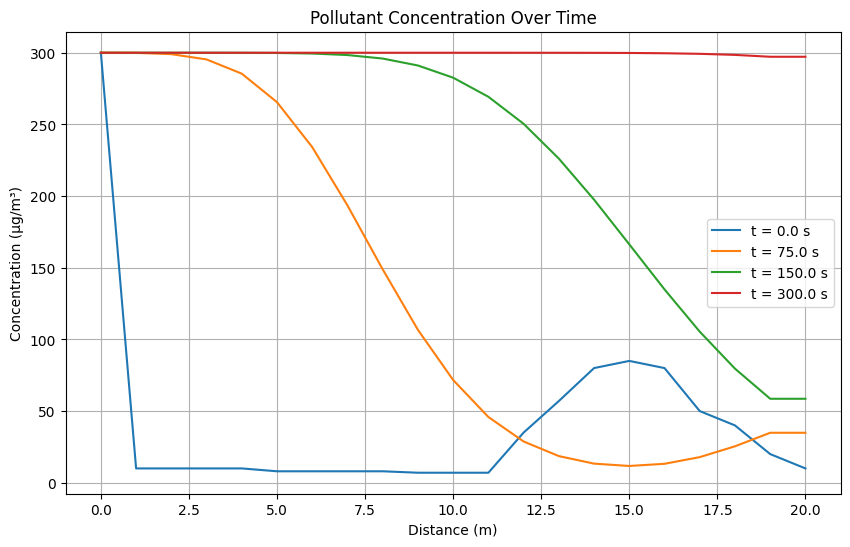

In [9]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files # for uploading the initial conditions CSV file
# this opens the tools and libraries for nunbers, making and plotting grpahs , lets user uploud csv files

# ask user for temporal domain data
t_start = 0 # start at t=0
t_end = float(input("Enter end of time domain (s): ")) # how long the simulations runs for by the user
dt = float(input("Enter temporal resolution dt (s): ")) # how big each step is, the time step size

# ask user for spatial resolution
dx = float(input("Enter spatial resolution (m): "))

# ask user for flow speed
U = float(input("Enter the flow speed (m/s): "))

# ask user for the decay constant for exponential decay
lambda_decay = float(input("Enter the decay constant (1/s): "))

# ask user for the decay constant for perturbation input
perturbation_factor = float(input("Enter the perturbation factor: "))

# ask user to upload the initial conditions CSV
print("Upload your initial conditions CSV file:")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# loads distance from first column and concentration data from second from CSV
file_data = np.loadtxt(file_name, delimiter=',', skiprows=1, encoding='latin1')
csv_x = file_data[:, 0]
csv_theta = file_data[:, 1]

# create a uniform spatial grid based on dx
x = np.arange(np.min(csv_x), np.max(csv_x) + dx, dx)

# interpolate concentration data onto the model
theta = np.interp(x, csv_x, csv_theta)
theta0 = theta[0] # store the initial upstream concentration for use in decay

# CFL stability check, precent unstable results if conditon is invali, step is adjusted
C = U * dt / dx
if C > 1:
    new_dt = dx / U
    print(f"The CFL condition has been violated, temporal resolution has been adjusted to {new_dt:.4f} s")
    dt = new_dt

# initialise the time domain
t = np.arange(t_start, t_end + dt, dt)

# function to apply random pertubations to U
def variable_velocity(U, pertubation_factor, num_points):
  pertubation = 1 + (pertubation_factor) * np.random.randn(num_points)
  U_variable = U * pertubation
  return U_variable

# finite difference method, functions increases fucntion by one time step
def FDM(theta, U_variable, dt, dx):
    # Calculate CFL number for each spatial point (C should be an array)
    C = U_variable * dt / dx

    new_theta = np.zeros_like(theta)

    for i in range(1, len(theta) - 1):
        # Use the perturbed velocity profile (U_variable) and apply finite difference
        new_theta[i] = theta[i] - C[i] * (theta[i] - theta[i - 1])

    # a zero gradient boundary condition at downstream for smooth outflow
    new_theta[-1] = new_theta[-2]

    return new_theta


# run the simulation, initialises the array to store concentration results for all time steps and locations
results = np.zeros((len(t), len(x)))
results[0, :] = theta

for n in range(1, len(t)): # time loop, updates concentration at each time step and applies boundary conditions and stores results

    theta[0] = theta0 * np.exp(-lambda_decay * t[n])

    U_variable = variable_velocity(U, perturbation_factor, len(x))

    theta = FDM(theta, U_variable, dt, dx)

    theta[0] = np.interp(0, csv_x, csv_theta)

    results[n, :] = theta

# plot results at selected times snapshots, to visualise how pollutant chnages with time
plt.figure(figsize=(10,6))
snapshot_times = [0, len(t)//4, len(t)//2, len(t)-1]  # 0%, 25%, 50%, 100% through time
#specific specific time step to show how concentration changes with time
for s in snapshot_times:
    plt.plot(x, results[s], label=f"t = {t[s]} s")
#plot concentration along space domain for each snapshot that was seleceted
plt.xlabel("Distance (m)")
plt.ylabel("Concentration (µg/m³)")
plt.title("Pollutant Concentration Over Time")
plt.legend()
plt.grid()
plt.show() # label graphs with units, titles, legend and improve readability of plot